<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/rankers_hmdata_multi_task_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -q tensorflow-recommenders
!pip3 install -q --upgrade tensorflow-datasets
!pip3 install -q scann

     |████████████████████████████████| 89 kB 3.8 MB/s 
     |████████████████████████████████| 4.7 MB 2.9 MB/s 
     |████████████████████████████████| 10.4 MB 4.5 MB/s 
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 5.9 MB 47.6 MB/s 
     |████████████████████████████████| 1.7 MB 55.9 MB/s 
     |████████████████████████████████| 438 kB 59.2 MB/s 


In [2]:
from IPython.core.display import Image, display
display(Image(url='https://miro.medium.com/max/3688/1*rrIJOpJO8fkFECNHlwq-jQ.png', width=500, unconfined=True))

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Dict, Text
from functools import reduce
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
#import tensorflow_recommenders as tfrs
from tensorflow import feature_column
import random
from datetime import timedelta
import gc


In [4]:

!gdown https://drive.google.com/uc?id=1rEJFi98sLUTYj50Fh8ff33A7NKOoT87c
#!gdown https://drive.google.com/uc?id=13JK5eo99X7RAVRG45te96FUx0uHhYjRs
#!gdown https://drive.google.com/uc?id=13lNaifdLn7i9IC_NE8JvTooqC-rvbR3k


Downloading...
From: https://drive.google.com/uc?id=1rEJFi98sLUTYj50Fh8ff33A7NKOoT87c
To: /content/hmdata.zip
100% 773M/773M [00:09<00:00, 83.6MB/s]


In [5]:
!unzip /content/hmdata.zip

Archive:  /content/hmdata.zip
   creating: hmdata/
  inflating: hmdata/customers.csv.zip  
  inflating: __MACOSX/hmdata/._customers.csv.zip  
  inflating: hmdata/articles.csv.zip  
  inflating: __MACOSX/hmdata/._articles.csv.zip  
  inflating: hmdata/transactions_train.csv.zip  
  inflating: __MACOSX/hmdata/._transactions_train.csv.zip  
  inflating: hmdata/sample_submission.csv.zip  
  inflating: __MACOSX/hmdata/._sample_submission.csv.zip  


In [6]:
article_df = pd.read_csv('hmdata/articles.csv.zip')
customer_df = pd.read_csv('hmdata/customers.csv.zip')
transaction_df =pd.read_csv('hmdata/transactions_train.csv.zip')


In [7]:
article_df = article_df.drop_duplicates(subset=['article_id','product_group_name','colour_group_name','section_name'])
customer_df = customer_df.drop_duplicates(subset=['customer_id','age'])
transaction_df = transaction_df.drop_duplicates(subset=['customer_id','price'])
train0 = transaction_df

In [8]:
N_CUSTOMERS = 80000
N_DAYS_TRAIN = 90
N_DAYS_TEST = 15

train0['t_dat']= pd.to_datetime(train0['t_dat'])
max_date = train0['t_dat'].max()
train_start = max_date - timedelta(days=N_DAYS_TRAIN)
train_end = max_date - timedelta(days=N_DAYS_TEST)

In [9]:
small_customer_set = customer_df[customer_df.customer_id.isin(customer_df.customer_id.sample(N_CUSTOMERS, random_state=0))].reset_index(drop=True)
small_transaction_set = transaction_df[transaction_df.customer_id.isin(small_customer_set.customer_id)].copy().reset_index(drop=True)
small_article_set = article_df[article_df.article_id.isin(small_transaction_set.article_id)].copy().reset_index(drop=True)

In [10]:
train0 = small_transaction_set

In [11]:
print(f' Shape of train0: {train0.shape}')
print(f' Shape of small_customer_set: {small_customer_set.shape}')
print(f' Shape of small_transaction_set: {small_transaction_set.shape}')
print(f' Shape of small_article_set: {small_article_set.shape}')

 Shape of train0: (794595, 5)
 Shape of small_customer_set: (80000, 7)
 Shape of small_transaction_set: (794595, 5)
 Shape of small_article_set: (69698, 25)


#### Split the data into training and testing sets


In [12]:
train = train0[(train0['t_dat']>=train_start) & (train0['t_dat']<=train_end)]
test = train0[(train0['t_dat']>train_end)]
train.shape, test.shape

((63666, 5), (9032, 5))

In [13]:
train = train.merge(small_article_set, on='article_id', how='left')
test = test.merge(small_article_set, on='article_id', how='left')

In [14]:
train.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [15]:
train= train[['t_dat','customer_id','article_id','price','product_group_name','colour_group_name','section_name']]
test = test[['t_dat','customer_id','article_id','price','product_group_name','colour_group_name','section_name']]

In [16]:
def is_popular(train):
    f2= train.groupby(['section_name','article_id'], as_index=False).size()
    f2['rank'] = f2.groupby(['section_name'])['size'].rank(method='dense', ascending=False)
    f2['mean_rank']= f2.groupby(['section_name'])['rank'].transform(lambda x: x.mean())
    f2['is_popular'] = f2.apply(lambda x: 1 if x['rank']< x['mean_rank'] else 0, axis=1)
    return f2[['article_id','is_popular','section_name']].reset_index(drop=True)

popular = is_popular(train)

In [17]:
popular = is_popular(train)

In [18]:
train = train.merge(popular, on='article_id', how='left', copy=False)
test = test.merge(popular, on='article_id', how='left', copy=False)
test = test.drop(['section_name_y'], axis=1)
test = test.rename(columns={'section_name_x':'section_name'})
test = test.fillna(0)
train = train.drop(['section_name_y'], axis=1)
train = train.rename(columns={'section_name_x':'section_name'})


In [19]:
test.head(2)

,t_dat,customer_id,article_id,price,product_group_name,colour_group_name,section_name,is_popular
0,2020-09-08,0155a6f04954055d0e916831ebabf8948b8e7edc30e0e3...,855507001,0.009136,Items,Pink,Womens Small accessories,1.0
1,2020-09-08,0155a6f04954055d0e916831ebabf8948b8e7edc30e0e3...,717490008,0.007610,Garment Upper body,Pink,Divided Basics,1.0


In [20]:
test.is_popular.value_counts()

0.0    4969
1.0    4063
Name: is_popular, dtype: int64

#### Numeric Features

In [21]:
def numeric_features(train):
    f11 = train.groupby("customer_id", as_index=False).article_id.nunique() #unique articles
    f21 = train.groupby("customer_id", as_index=False).t_dat.nunique() #days active
    f31 = train.groupby("customer_id", as_index=False).size() #total purchases
    f51 = train.groupby("customer_id", as_index=False).section_name.nunique() #num unique section_name

    data_frames = [f11,f21,f31,f51]
    customer_features_agg_df = reduce(lambda  left,right: pd.merge(left, right, on=['customer_id'], how='outer'), data_frames)
    customer_features_agg_df.columns = ['customer_id', 'nArticles', 'nDays', 'nPurchases', 'nSect']
    return customer_features_agg_df.reset_index(drop=True)


numeric_features_by_user = numeric_features(train)

#### Age Interval

In [22]:
def create_age_interval(x):
    if x <= 20:
        return "Teenaage"
    elif x <= 35:
        return "Working Age"
    elif x <= 55:
        return  "Middle Age"
    else:
        return  "Senior Age"


# Set missing values in age with the median
small_customer_set["age"].fillna(small_customer_set["age"].median(), inplace=True)
small_customer_set["age_interval"] = small_customer_set["age"].apply(lambda x: create_age_interval(x))
small_customer_set_reduced= small_customer_set.drop(columns=['age','FN','Active','club_member_status','fashion_news_frequency','postal_code']).reset_index(drop=True)


In [23]:
data_frames = [numeric_features_by_user , small_customer_set_reduced]
customer_features_agg_df = reduce(lambda  left,right: pd.merge(left, right, on=['customer_id'], how='outer'), data_frames)
customer_features_agg_df.columns = ['customer_id', 'nArticles', 'nDays', 'nPurchases', 'nSect', 'age_interval']

In [24]:
train = train.merge(customer_features_agg_df, on='customer_id', how='left')
test = test.merge(customer_features_agg_df, on='customer_id', how='left')
test = test.dropna()

In [25]:
train.head(2)

,t_dat,customer_id,article_id,price,product_group_name,colour_group_name,section_name,is_popular,nArticles,nDays,nPurchases,nSect,age_interval
0,2020-06-24,0076383b0cb65133fab3ff5ece40994b8acc055ddb5d18...,826508002,0.016932,Garment Upper body,White,Womens Tailoring,1,3.0,2.0,3.0,2.0,Middle Age
1,2020-06-24,0076383b0cb65133fab3ff5ece40994b8acc055ddb5d18...,826508003,0.012695,Garment Upper body,Dark Blue,Womens Tailoring,1,3.0,2.0,3.0,2.0,Middle Age


In [26]:
test.isnull().sum()

t_dat                 0
customer_id           0
article_id            0
price                 0
product_group_name    0
colour_group_name     0
section_name          0
is_popular            0
nArticles             0
nDays                 0
nPurchases            0
nSect                 0
age_interval          0
dtype: int64

In [27]:
test.shape

(4096, 13)

In [28]:
test.head(2)

,t_dat,customer_id,article_id,price,product_group_name,colour_group_name,section_name,is_popular,nArticles,nDays,nPurchases,nSect,age_interval
11,2020-09-08,05e0a597465504e1e73bef0b9253cdc6129c8299cb245d...,762846027,0.023932,Garment Upper body,Beige,Womens Tailoring,0.0,4.0,2.0,4.0,4.0,Middle Age
12,2020-09-08,05e0a597465504e1e73bef0b9253cdc6129c8299cb245d...,797608001,0.038305,Garment Upper body,Yellow,Special Collections,0.0,4.0,2.0,4.0,4.0,Middle Age


In [29]:
# Use 40k customers from train only so we can quickly test our methods
CUSTOMER_IDS = set(train['customer_id'].unique()) & set(test['customer_id'].unique())
train = train[train['customer_id'].isin(CUSTOMER_IDS)].reset_index(drop=True)
test = test[test['customer_id'].isin(CUSTOMER_IDS)].reset_index(drop=True)

train.shape, test.shape, train['customer_id'].nunique(), test['customer_id'].nunique()

((7368, 13), (4096, 13), 2204, 2204)

## Negative Sampling

In [30]:
liked_articles = pd.concat([train,test], axis=0)
liked_articles.head(2)

,t_dat,customer_id,article_id,price,product_group_name,colour_group_name,section_name,is_popular,nArticles,nDays,nPurchases,nSect,age_interval
0,2020-06-24,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,678342028,0.006661,Garment Upper body,White,Divided Basics,1.0,9.0,1.0,9.0,4.0,Working Age
1,2020-06-24,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,863937010,0.011678,Garment Upper body,Black,Womens Everyday Basics,1.0,9.0,1.0,9.0,4.0,Working Age


In [31]:
customer_liked_article= liked_articles.groupby("customer_id", as_index=False).article_id.agg(['unique']).reset_index()
customer_liked_article.columns = ['customer_id', 'article_list']
customer_liked_article.head(2)

,customer_id,article_list
0,0015f16aa2702e2ec13d2e38052f496b9b915d3c64e82c...,"[891238001, 865929007, 751471038]"
1,002cf96a2e882620182534ca963f8b43f9aafa2b668c09...,"[843777005, 894756005, 892280003, 859125001, 8..."


In [32]:
articlesSet_train = list(train.article_id.unique())
articlesSet_test = list(test.article_id.unique())

In [33]:
def generate_negative_samples(train_df, article_list, num_neg=1):
    """
    Simple random sampling for generative negative examples
    """
    negData = []
    for index, row in train_df.iterrows():
        allList = article_list
        cust = row['customer_id']
        art_list = row['article_list']
        allList = list(set(allList) - set(art_list))
        negs = random.sample(allList, num_neg)
        for n in negs:
            negData.append([cust,n])
    negDf = pd.DataFrame(negData,columns=['customer_id','article_id'])
    return negDf

In [34]:
negDf_train = generate_negative_samples(customer_liked_article,articlesSet_train,1) #2 negative samples per customer
negDf_test = generate_negative_samples(customer_liked_article,articlesSet_test,1) #2 negative samples per customer


In [35]:
negDf_test.head(2)

,customer_id,article_id
0,0015f16aa2702e2ec13d2e38052f496b9b915d3c64e82c...,748595003
1,002cf96a2e882620182534ca963f8b43f9aafa2b668c09...,717490076


In [36]:
train.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'product_group_name',
       'colour_group_name', 'section_name', 'is_popular', 'nArticles', 'nDays',
       'nPurchases', 'nSect', 'age_interval'],
      dtype='object')

In [37]:
article_features = train[['article_id', 'price', 'product_group_name',
       'colour_group_name', 'section_name']]
customer_features = train[['customer_id', 'age_interval', 'nArticles', 'nDays', 'nPurchases', 'nSect']]

In [38]:
article_features_test = test[['article_id', 'price', 'product_group_name', 'colour_group_name', 'section_name']]
customer_features_test = test[['customer_id', 'age_interval', 'nArticles', 'nDays', 'nPurchases', 'nSect']]

In [39]:
negDf_train = negDf_train.merge(article_features, on='article_id', how='left') # merge negative samples with article features
negDf_train = negDf_train.merge(customer_features, on='customer_id', how='left') # merge negative samples with customer features

In [40]:
negDf_train.head(2)

,customer_id,article_id,price,product_group_name,colour_group_name,section_name,age_interval,nArticles,nDays,nPurchases,nSect
0,0015f16aa2702e2ec13d2e38052f496b9b915d3c64e82c...,678942039,0.013068,Garment Upper body,Orange,"Womens Nightwear, Socks & Tigh",Senior Age,1.0,1.0,1.0,1.0
1,002cf96a2e882620182534ca963f8b43f9aafa2b668c09...,865490002,0.022017,Garment Upper body,White,Divided Collection,Middle Age,7.0,1.0,7.0,4.0


In [41]:
negDf_test = negDf_test.merge(article_features_test, on='article_id', how='left') # merge negative samples with article features
negDf_test = negDf_test.merge(customer_features_test, on='customer_id', how='left') # merge negative samples with customer features

In [42]:
negDf_test.head(2)

,customer_id,article_id,price,product_group_name,colour_group_name,section_name,age_interval,nArticles,nDays,nPurchases,nSect
0,0015f16aa2702e2ec13d2e38052f496b9b915d3c64e82c...,748595003,0.06778,Shoes,Dark Beige,Womens Shoes,Senior Age,1.0,1.0,1.0,1.0
1,0015f16aa2702e2ec13d2e38052f496b9b915d3c64e82c...,748595003,0.06778,Shoes,Dark Beige,Womens Shoes,Senior Age,1.0,1.0,1.0,1.0


In [43]:
negDf_test.isnull().sum()

customer_id           0
article_id            0
price                 0
product_group_name    0
colour_group_name     0
section_name          0
age_interval          0
nArticles             0
nDays                 0
nPurchases            0
nSect                 0
dtype: int64

In [44]:
train['label'] = 1
negDf_train['label'] = 0
test['label'] = 1
negDf_test['label'] = 0

In [45]:
train_data = pd.concat([train,negDf_train], axis=0).reset_index(drop=True) # merge positive and negative samples
train_data.fillna(0, inplace=True) # fill missing values with 0
test_data = pd.concat([test,negDf_test], axis=0).reset_index(drop=True) # merge positive and negative samples
test_data.fillna(0, inplace=True) # fill missing values with 0

In [46]:
train_data.isnull().sum()

t_dat                 0
customer_id           0
article_id            0
price                 0
product_group_name    0
colour_group_name     0
section_name          0
is_popular            0
nArticles             0
nDays                 0
nPurchases            0
nSect                 0
age_interval          0
label                 0
dtype: int64

In [47]:
train_data.shape, test_data.shape

((18382, 14), (10516, 14))

In [48]:
test_data.isnull().sum()

t_dat                 0
customer_id           0
article_id            0
price                 0
product_group_name    0
colour_group_name     0
section_name          0
is_popular            0
nArticles             0
nDays                 0
nPurchases            0
nSect                 0
age_interval          0
label                 0
dtype: int64

In [49]:
print(f'train data labels  {train_data.label.value_counts()}')
print(f'test data labels  {test_data.label.value_counts()}')


train data labels  0    11014
1     7368
Name: label, dtype: int64
test data labels  0    6420
1    4096
Name: label, dtype: int64


In [50]:
from  sklearn.preprocessing import StandardScaler

def normalize(subset, test_mode=False, scaler=None):
    '''
    subset = dataframe containg all the data
    returns = scaled data for all the int and float colmuns along with the
             non numeric data
    filter:
         scaler type:
         1. MinMax Scaler : 'minmax'
         2. Standard Scaler : 'standard'
         3. Robust Scaler : 'robust'
    '''
 
    continious_columns = subset.select_dtypes(include=['float32','float64']).columns
    categorical_columns = subset.select_dtypes(include=['object']).columns
    numeric_columns = subset.select_dtypes(include=['int64','int32']).columns
    non_numeric_columns = subset.select_dtypes(exclude=['float32','float64','int64','int32','object']).columns
    if not test_mode:
        scaler = StandardScaler()
        scaler.fit(subset[continious_columns])
    scaled_data = scaler.transform(subset[continious_columns])
    scaled_data = pd.DataFrame(scaled_data, columns=continious_columns)
    scaled_data = pd.concat([scaled_data, subset[categorical_columns], subset[numeric_columns]], axis=1)
    scaled_data = pd.concat([scaled_data, subset[non_numeric_columns]], axis=1)
    return scaled_data, scaler

In [51]:
train_data_scaled, scaler = normalize(train_data) # normalize train data
test_data_scaled, _ = normalize(test_data, test_mode=True, scaler=scaler) # normalize test data with the same scaler

In [52]:
train_data_scaled.head(2)

,price,is_popular,nArticles,nDays,nPurchases,nSect,t_dat,customer_id,product_group_name,colour_group_name,section_name,age_interval,article_id,label
0,-0.810391,1.585576,1.004353,-0.906493,0.94648,0.271868,2020-06-24 00:00:00,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,Garment Upper body,White,Divided Basics,Working Age,678342028,1
1,-0.605451,1.585576,1.004353,-0.906493,0.94648,0.271868,2020-06-24 00:00:00,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,Garment Upper body,Black,Womens Everyday Basics,Working Age,863937010,1


In [53]:
test_data_scaled.head(2)

,price,is_popular,nArticles,nDays,nPurchases,nSect,t_dat,customer_id,product_group_name,colour_group_name,section_name,age_interval,article_id,label
0,-0.104873,-0.630686,-0.364076,-0.205359,-0.383129,0.271868,2020-09-08 00:00:00,05e0a597465504e1e73bef0b9253cdc6129c8299cb245d...,Garment Upper body,Beige,Womens Tailoring,Middle Age,762846027,1
1,0.482251,-0.630686,-0.364076,-0.205359,-0.383129,0.271868,2020-09-08 00:00:00,05e0a597465504e1e73bef0b9253cdc6129c8299cb245d...,Garment Upper body,Yellow,Special Collections,Middle Age,797608001,1


## Single Task Model

In [54]:

# Declaring Numerical and Categorical Columns
numeric_features =['price', 'nArticles', 'nDays', 'nPurchases', 'nSect','is_popular'] 
categorical_features_product  = ['product_group_name'] 
categorical_features_color = ['colour_group_name']
categorical_features_section = ['section_name']
categorical_features_age = ['age_interval']
categorical_article_id = ['article_id']
categorical_customer_id = ['customer_id']


# Converting Numeric Columns to array and Categorical Columns to Strig
numeric_data = train_data_scaled[numeric_features].values # convert to numpy array
categorical_data = train_data_scaled[categorical_features_product].astype('str') 
categorical_data_color = train_data_scaled[categorical_features_color].astype('str') 
categorical_data_section = train_data_scaled[categorical_features_section].astype('str')
categorical_data_age = train_data_scaled[categorical_features_age].astype('str')
categorical_data_article_id = train_data_scaled[categorical_article_id].astype('str')
categorical_data_customer_id = train_data_scaled[categorical_customer_id].astype('str')
target = train_data_scaled['label'].values

#numeric inputs
input2numeric_layer = tf.keras.Input((len(numeric_features)), name='numeric_input') # input layer
numeric_layer = tf.keras.layers.Dense(100, activation='relu')(input2numeric_layer) # hidden layer
numeric_layer = tf.keras.layers.Dense(100, activation='relu')(numeric_layer) # hidden layer

unique_article_ids = categorical_data_article_id['article_id'].unique().astype(str)
input2articleid_layer = tf.keras.Input((1,), name='article_id', dtype=tf.string) 
categrorical2articleIdlookup = tf.keras.layers.StringLookup(vocabulary=unique_article_ids, mask_token=None)(input2articleid_layer) # lookup layer
numeric_article_id =  tf.keras.layers.Embedding(len(unique_article_ids) + 1, 64)(categrorical2articleIdlookup) 
numeric_article_id = tf.keras.layers.Dense(100)(numeric_article_id)
numeric_article_id = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, 1))(numeric_article_id)




#categorical features creating one hot encoding for each categorical feature using String Lookup
unique_product_names = categorical_data['product_group_name'].unique().astype(str) # get unique product names
input2categorical_layer = tf.keras.Input((1,), name='categorical_input', dtype=tf.string) # input layer
categrorical2Stringlookup = tf.keras.layers.StringLookup(vocabulary=unique_product_names, output_mode='one_hot')(input2categorical_layer) # lookup layer

uniquee_color_names = categorical_data_color['colour_group_name'].unique().astype(str) # get unique color names
input2categorical_layer_color = tf.keras.Input((1,), name='categorical_input_color', dtype=tf.string) # input layer
categrorical2Stringlookup_color = tf.keras.layers.StringLookup(vocabulary=uniquee_color_names, output_mode='one_hot')(input2categorical_layer_color) # lookup layer

unique_section_names = categorical_data_section['section_name'].unique().astype(str) # get unique section names
input2categorical_layer_section = tf.keras.Input((1,), name='categorical_input_section', dtype=tf.string) # input layer
categrorical2Stringlookup_section = tf.keras.layers.StringLookup(vocabulary=unique_section_names, output_mode='one_hot')(input2categorical_layer_section) # lookup layer

unique_age_intervals = categorical_data_age['age_interval'].unique().astype(str) # get unique age intervals
input2categorical_layer_age = tf.keras.Input((1,), name='categorical_input_age', dtype=tf.string) # input layer
categrorical2Stringlookup_age = tf.keras.layers.StringLookup(vocabulary=unique_age_intervals, output_mode='one_hot')(input2categorical_layer_age) # lookup layer


#concatenating the categorical and numeric layers

concatenated_layer = tf.keras.layers.concatenate([numeric_article_id, numeric_layer, categrorical2Stringlookup, categrorical2Stringlookup_color, categrorical2Stringlookup_section,categrorical2Stringlookup_age ])
#concatenated_layer = tf.keras.layers.concatenate([numeric_layer, categrorical2Stringlookup]) # concatenate layer
#concatenated_layer = tf.keras.layers.concatenate([concatenated_layer, categrorical2Stringlookup_color]) # concatenate layer
#concatenated_layer = tf.keras.layers.concatenate([concatenated_layer, categrorical2Stringlookup_section]) # concatenate layer
#concatenated_layer = tf.keras.layers.concatenate([concatenated_layer, categrorical2Stringlookup_age]) # concatenate layer
concatenated_layer2dense = tf.keras.layers.Dense(100, activation='relu')(concatenated_layer) # hidden layer
concatenated_layer2dense = tf.keras.layers.Dense(10, activation='relu')(concatenated_layer2dense) # hidden layer
concatenated_layer2output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated_layer2dense) # output layer





In [55]:
cost_function = tf.keras.losses.BinaryCrossentropy(from_logits=False) # cost function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # optimizer
metric = tf.keras.metrics.BinaryAccuracy() # metric

In [56]:
model = tf.keras.Model(inputs=[input2articleid_layer,
                               input2numeric_layer, 
                               input2categorical_layer,
                               input2categorical_layer_color,
                               input2categorical_layer_section,
                               input2categorical_layer_age], outputs=concatenated_layer2output) # model

In [57]:
model.summary() # print model summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 article_id (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['article_id[0][0]']             
                                                                                                  
 embedding (Embedding)          (None, 1, 64)        311808      ['string_lookup[0][0]']          
                                                                                                  
 numeric_input (InputLayer)     [(None, 6)]          0           []                               
                                                                                              

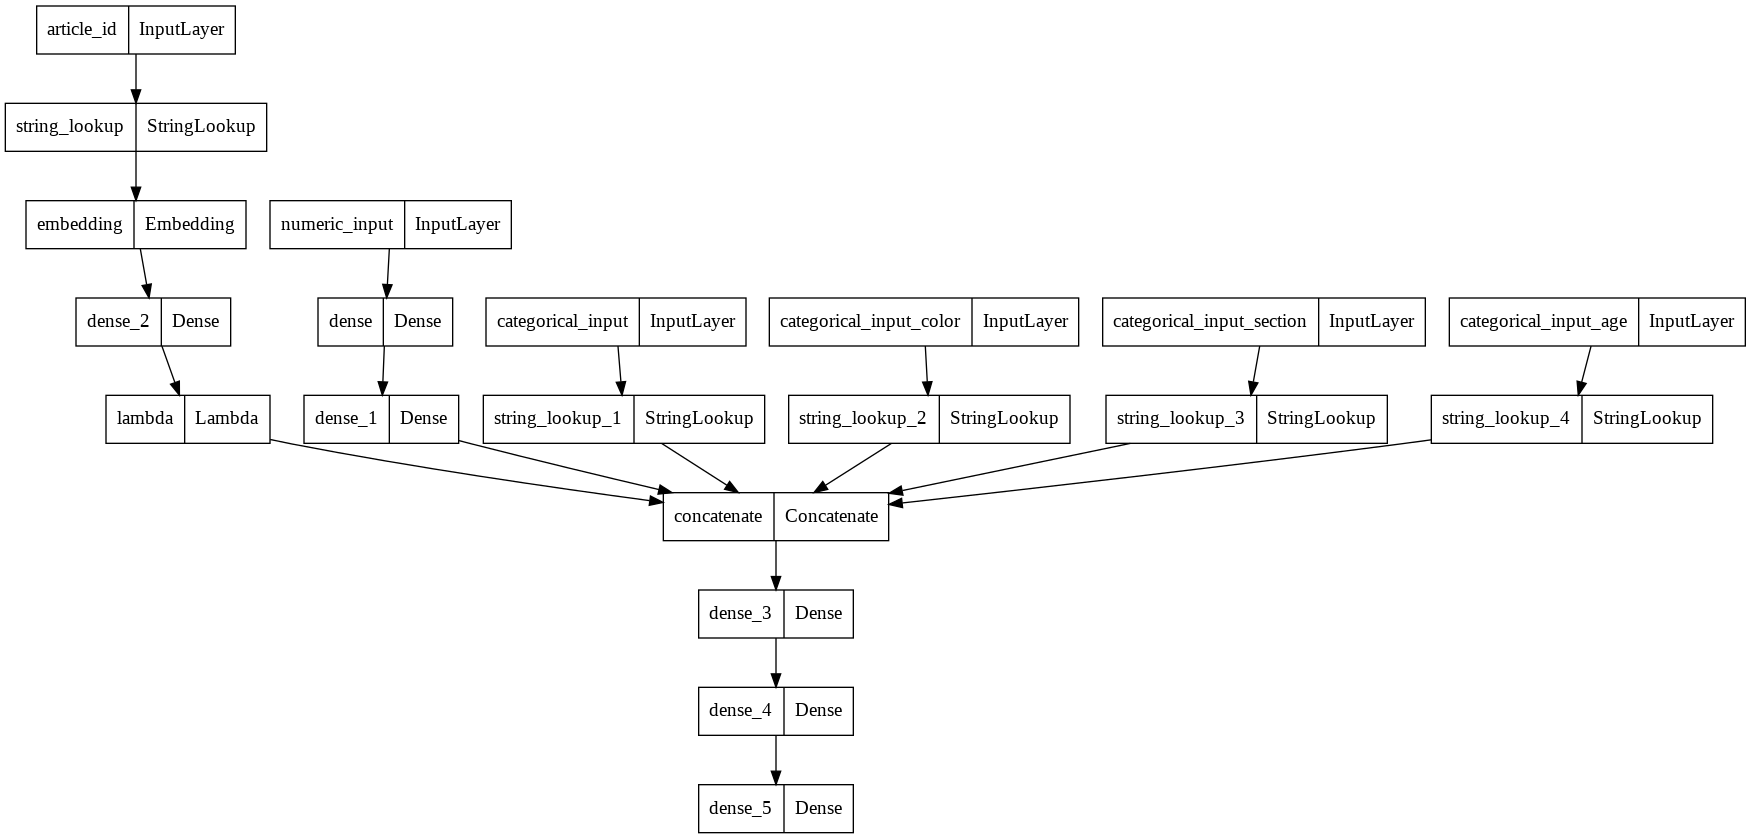

In [58]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [59]:
model.compile(optimizer=optimizer, loss=cost_function, metrics=[metric]) # compile model

In [60]:
model.fit(x=[categorical_data_article_id,
             numeric_data, 
             categorical_data,categorical_data_color, 
             categorical_data_section, 
             categorical_data_age ], y=target, epochs=8) # train model

Epoch 1/8
575/575 [==============================] - 6s 9ms/step - loss: 0.2574 - binary_accuracy: 0.9017
Epoch 2/8
575/575 [==============================] - 5s 8ms/step - loss: 0.1253 - binary_accuracy: 0.9576
Epoch 3/8
575/575 [==============================] - 5s 8ms/step - loss: 0.0944 - binary_accuracy: 0.9700
Epoch 4/8
575/575 [==============================] - 5s 8ms/step - loss: 0.0774 - binary_accuracy: 0.9731
Epoch 5/8
575/575 [==============================] - 5s 8ms/step - loss: 0.0617 - binary_accuracy: 0.9748
Epoch 6/8
575/575 [==============================] - 5s 8ms/step - loss: 0.0523 - binary_accuracy: 0.9776
Epoch 7/8
575/575 [==============================] - 5s 9ms/step - loss: 0.0454 - binary_accuracy: 0.9796
Epoch 8/8
575/575 [==============================] - 5s 8ms/step - loss: 0.0423 - binary_accuracy: 0.9816


In [61]:
def evaluate(df):
    X0 = df['article_id'].astype(str)
    X1 = np.asarray(df[numeric_features].values)
    X2 = df['product_group_name'].astype(str)
    X3 = df['colour_group_name'].astype(str)
    X4 = df['section_name'].astype(str)
    X5 = df['age_interval'].astype(str)
    preds = model.predict([X0, X1, X2, X3, X4, X5])
    preds = (preds>=0.5).astype(int).flatten()
    print(sum(preds == df['label'].values)/len(preds))
    return preds


evaluate(test_data_scaled)

329/329 [==============================] - 1s 2ms/step
0.6667934575884367


array([1, 1, 1, ..., 0, 1, 1])

In [62]:
np.bincount(evaluate(test_data_scaled))

329/329 [==============================] - 1s 2ms/step
0.6667934575884367


array([5838, 4678])

329/329 [==============================] - 1s 2ms/step
0.6667934575884367
329/329 [==============================] - 1s 2ms/step
0.6667934575884367


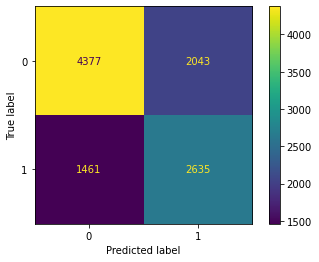

In [63]:
from cProfile import label
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

confusion_matrix(test_data_scaled['label'].values, evaluate(test_data_scaled))
cm = confusion_matrix(test_data_scaled['label'].values, evaluate(test_data_scaled), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format = '.0f')
plt.grid(False)
plt.show()

## Multi Task Model

In [64]:
# Add the second label for multi-task learning (whether the user would purchase an article from that product_group_name)

customer2productgroups = dict(train.groupby('customer_id')['product_group_name'].apply(lambda x: set(list(x))))

def add_label2_to_trainDF(train_data_scaled, test_data_scaled):
    """
    write code here to add a new column to trainDF
    the new column would be named label2 and it represents the label for the task 2
    
    After this function has been run, it can be safely assumed that trainDF dataframe contains another column called "label2"
    that describes the label for the second prediction task.
    """
    liked_articles = pd.concat([train_data_scaled, test_data_scaled], axis=0)
    liked_articles =liked_articles[liked_articles['label']==1]
    
    customer2productgroup = liked_articles.groupby('customer_id').product_group_name.apply(list).reset_index()
    customer2productgroup.columns = ['customer_id', 'product_list']
    customer2productgroup.head(2)

    train_data_scaled= train_data_scaled.merge(customer2productgroup, on='customer_id', how='left')
    train_data_scaled['product_category_label'] = train_data_scaled.apply(lambda x: 1 if x.product_group_name in x.product_list else 0, axis=1)

    test_data_scaled = test_data_scaled.merge(customer2productgroup, on='customer_id', how='left')
    test_data_scaled['product_category_label'] = test_data_scaled.apply(lambda x: 1 if x.product_group_name in x.product_list else 0, axis=1)

    return train_data_scaled, test_data_scaled



In [65]:
train_data_scaled, test_data_scaled = add_label2_to_trainDF(train_data_scaled, test_data_scaled)

In [66]:
train_data_scaled.head(2)

,price,is_popular,nArticles,nDays,nPurchases,nSect,t_dat,customer_id,product_group_name,colour_group_name,section_name,age_interval,article_id,label,product_list,product_category_label
0,-0.810391,1.585576,1.004353,-0.906493,0.94648,0.271868,2020-06-24 00:00:00,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,Garment Upper body,White,Divided Basics,Working Age,678342028,1,"[Garment Upper body, Garment Upper body, Garme...",1
1,-0.605451,1.585576,1.004353,-0.906493,0.94648,0.271868,2020-06-24 00:00:00,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,Garment Upper body,Black,Womens Everyday Basics,Working Age,863937010,1,"[Garment Upper body, Garment Upper body, Garme...",1


In [67]:
# Declaring Numerical and Categorical Columns
numeric_features =['price', 'nArticles', 'nDays', 'nPurchases', 'nSect','is_popular'] 
categorical_features_product  = ['product_group_name'] 
categorical_features_color = ['colour_group_name']
categorical_features_section = ['section_name']
categorical_features_age = ['age_interval']

# Converting Numeric Columns to array and Categorical Columns to Strig
numeric_data = train_data_scaled[numeric_features].values # convert to numpy array
categorical_data = train_data_scaled[categorical_features_product].astype('str') 
categorical_data_color = train_data_scaled[categorical_features_color].astype('str') 
categorical_data_section = train_data_scaled[categorical_features_section].astype('str')
categorical_data_age = train_data_scaled[categorical_features_age].astype('str')
target1 = train_data_scaled['label'].values
target2 = train_data_scaled['product_category_label'].values


#numeric inputs
input2numeric_layer = tf.keras.Input((len(numeric_features)), name='numeric_input') # input layer
numeric_layer = tf.keras.layers.Dense(100, activation='relu')(input2numeric_layer) # hidden layer
numeric_layer = tf.keras.layers.Dense(100, activation='relu')(numeric_layer) # hidden layer

#categorical features creating one hot encoding for each categorical feature using String Lookup
unique_product_names = categorical_data['product_group_name'].unique().astype(str) # get unique product names
input2categorical_layer = tf.keras.Input((1,), name='categorical_input', dtype=tf.string) # input layer
categrorical2Stringlookup = tf.keras.layers.StringLookup(vocabulary=unique_product_names, output_mode='one_hot')(input2categorical_layer) # lookup layer

#uniquee_color_names = categorical_data_color['colour_group_name'].unique().astype(str) # get unique color names
#input2categorical_layer_color = tf.keras.Input((1,), name='categorical_input_color', dtype=tf.string) # input layer
#categrorical2Stringlookup_color = tf.keras.layers.StringLookup(vocabulary=uniquee_color_names, output_mode='one_hot')(input2categorical_layer_color) # lookup layer

#unique_section_names = categorical_data_section['section_name'].unique().astype(str) # get unique section names
#input2categorical_layer_section = tf.keras.Input((1,), name='categorical_input_section', dtype=tf.string) # input layer
#categrorical2Stringlookup_section = tf.keras.layers.StringLookup(vocabulary=unique_section_names, output_mode='one_hot')(input2categorical_layer_section) # lookup layer
#
unique_age_intervals = categorical_data_age['age_interval'].unique().astype(str) # get unique age intervals
input2categorical_layer_age = tf.keras.Input((1,), name='categorical_input_age', dtype=tf.string) # input layer
categrorical2Stringlookup_age = tf.keras.layers.StringLookup(vocabulary=unique_age_intervals, output_mode='one_hot')(input2categorical_layer_age) # lookup layer


#concatenating the categorical and numeric layers
concatenated_layer = tf.keras.layers.concatenate([numeric_layer, categrorical2Stringlookup]) # concatenate layer
#concatenated_layer = tf.keras.layers.concatenate([concatenated_layer, categrorical2Stringlookup_color]) # concatenate layer
#concatenated_layer = tf.keras.layers.concatenate([concatenated_layer, categrorical2Stringlookup_section]) # concatenate layer
concatenated_layer = tf.keras.layers.concatenate([concatenated_layer, categrorical2Stringlookup_age]) # concatenate layer
common_layer  = tf.keras.layers.Dense(100, activation='relu')(concatenated_layer) # hidden layer


#Task 1: Predicting if the user will by the article id or not
# Nueral Network specific to the task 1
x1 = tf.keras.layers.Dense(32, activation='relu',name="task1a") (common_layer)
x1 = tf.keras.layers.Dense(32, activation='relu',name="task1b") (x1)
x1 = tf.keras.layers.Dense(1, activation='sigmoid',name="out1") (x1)

#Task 2  Predicting if the user will buy from this product category or not
# Nueral Network specific to the task 2
x2 = tf.keras.layers.Dense(32, activation='relu',name="task2a") (common_layer)
x2 = tf.keras.layers.Dense(32, activation='relu',name="task2b") (x2)
x2 = tf.keras.layers.Dense(1, activation='sigmoid',name="out2") (x2)

In [68]:
cost_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric = tf.keras.metrics.BinaryAccuracy()

In [69]:
model_mt = tf.keras.Model(inputs=[input2numeric_layer, input2categorical_layer, input2categorical_layer_age], outputs=[x1, x2]) #input2categorical_layer_color, input2categorical_layer_section, 
model_mt.compile(optimizer=optimizer, loss=cost_function, metrics=[metric])

In [70]:
model_mt.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_input (InputLayer)     [(None, 6)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 100)          700         ['numeric_input[0][0]']          
                                                                                                  
 categorical_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 100)          10100       ['dense_6[0][0]']                
                                                                                            

In [71]:
model_mt.fit([numeric_data, categorical_data, categorical_data_age], [target1, target2], epochs=10, batch_size=1000)

Epoch 1/10
19/19 [==============================] - 1s 12ms/step - loss: 1.2054 - out1_loss: 0.6028 - out2_loss: 0.6026 - out1_binary_accuracy: 0.7878 - out2_binary_accuracy: 0.7038
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 0.8086 - out1_loss: 0.3458 - out2_loss: 0.4628 - out1_binary_accuracy: 0.8830 - out2_binary_accuracy: 0.7619
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 0.7213 - out1_loss: 0.3179 - out2_loss: 0.4033 - out1_binary_accuracy: 0.8837 - out2_binary_accuracy: 0.7765
Epoch 4/10
19/19 [==============================] - 0s 14ms/step - loss: 0.6791 - out1_loss: 0.3160 - out2_loss: 0.3630 - out1_binary_accuracy: 0.8840 - out2_binary_accuracy: 0.8132
Epoch 5/10
19/19 [==============================] - 0s 13ms/step - loss: 0.6630 - out1_loss: 0.3137 - out2_loss: 0.3493 - out1_binary_accuracy: 0.8842 - out2_binary_accuracy: 0.8226
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.6561 - out1_los

In [72]:
def evaluate_multitask(df):
    X1 = np.asarray(df[numeric_features].values)
    X2 = df['product_group_name'].astype(str)
    #X3 = df['colour_group_name'].astype(str)
    #X4 = df['section_name'].astype(str)
    X5 = df['age_interval'].astype(str)
    preds_task1, preds_task2 = model_mt.predict([X1, X2, X5]) #X3, X4,
    preds_task1 = (preds_task1>=0.5).astype(int).flatten()
    preds_task2 = (preds_task2>=0.5).astype(int).flatten()
    print(sum(preds_task1 == df['label'].values)/len(preds_task1))
    print(sum(preds_task2 == df['product_category_label'].values)/len(preds_task2))
    return preds_task1, preds_task2




In [73]:
preds_task1, pred_task2= evaluate_multitask(test_data_scaled)

329/329 [==============================] - 1s 2ms/step
0.7801445416508178
0.7959300114111829


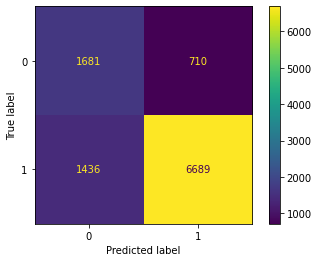

In [74]:
from cProfile import label
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

confusion_matrix(test_data_scaled['product_category_label'].values, pred_task2)

cm = confusion_matrix(test_data_scaled['product_category_label'].values, pred_task2, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

In [75]:
cm

array([[1681,  710],
       [1436, 6689]])

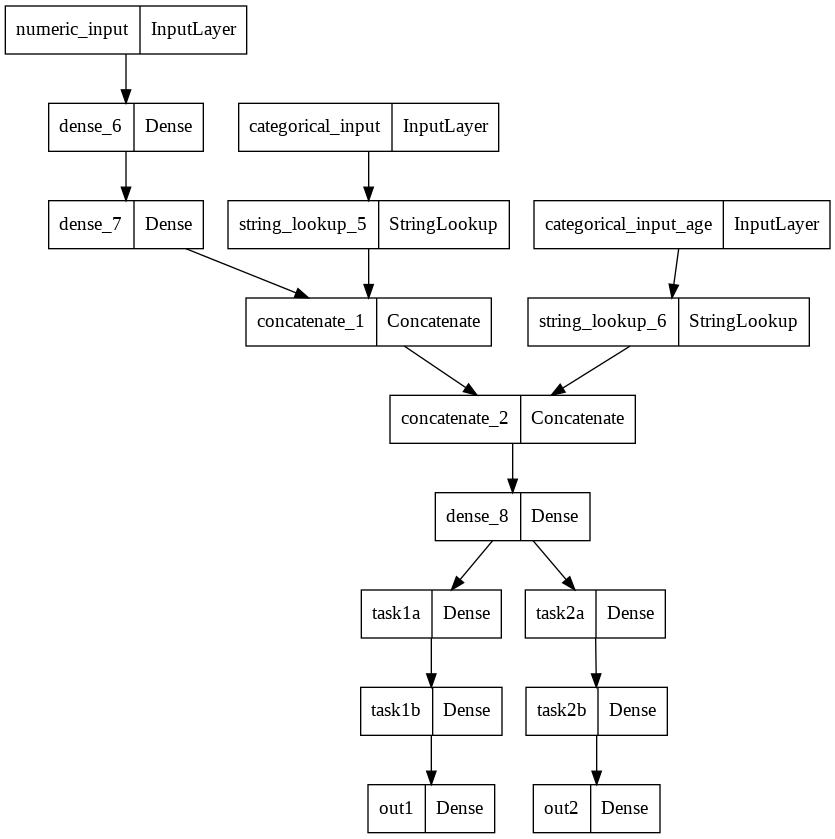

In [76]:
tf.keras.utils.plot_model(
    model_mt,
    to_file='model_multitask.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)